# Transient simulation of organic light emitting electrochemical cell

Idea and parameters taken from S.van Reenen, R.A.J.Janssen, M.Kemerink [Doping dynamics in light-emitting electrochemical cells](https://doi.org/10.1016/j.orgel.2011.07.005), Organic Electronics 12 (2011) 1746–1753.

In [1]:
from oedes.fvm import mesh1d
from oedes import solve, bdf1adapt, asarrays, interpolatearrays, testing
from oedes.models import lec
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from oedes.functions import Aux2

In [2]:
def mu_func(T, E, c):
    mu0 = 5e-11
    mu1 = 5e-9
    W = 0.04
    f0 = 0.3
    f = c / 0.3e27
    return (mu1 - mu0) * Aux2((f0 - f) / W) + mu0

In [3]:
mesh = mesh1d(2e-6)
model = lec.LEC(mesh)
xinit = lec.initial_salt(model, 0.1e27)

In [4]:
def solve(mu_ions, mu_charges, voltage=5.):
    params = {'T': 300.,
              'electron.mu': mu_charges,
              'electron.level': 0.,
              'electron.N0': 0.3e27,
              'hole.mu': mu_charges,  # 5e-11,
              'hole.level': 2.,
              'hole.N0': 0.3e27,
              'electrode0.workfunction': 2.,
              'electrode1.workfunction': 0.,
              'electrode0.voltage': voltage,
              'electrode1.voltage': 0,
              'cation.mu': mu_ions,
              'anion.mu': mu_ions,
              'npi': 0,
              'epsilon_r': 3.
              }
    return asarrays(
        lec.bdf1adapt(
            model,
            xinit,
            params,
            t=0.,
            t1=1.,
            dt=1e-9),
        monitor=lec.monitor_time,
        outputs=[
            'J',
            'R',
            'cation.c',
            'anion.c',
            'electron.c',
            'hole.c',
            'potential',
            'E'])

In [7]:
from matplotlib import colors


def niceplot(data):
    N0 = 5e27
    n = 20
    for it, t in enumerate(10**np.linspace(-5, -1, n + 1)):
        out = interpolatearrays(data, t)
        c = 1 - (1. - it / n)
        plt.plot(
            mesh.cells['center'] * 1e9,
            out['electron.c'] / N0,
            colors.rgb2hex(
                (1,
                 1 - c,
                 1 - c)))
        plt.plot(
            mesh.cells['center'] * 1e9,
            out['hole.c'] / N0,
            colors.rgb2hex(
                (1 - c,
                 1 - c,
                 1)))
        testing.store(out['electron.c'], rtol=1e-7, atol=1e-3 * N0)
        testing.store(out['hole.c'], rtol=1e-7, atol=1e-3 * N0)
    plt.yscale('log')
    plt.ylim([1e-5, 1.])
    plt.xlabel('$x$ [nm]')
    plt.ylabel('$c/N_0$')

## Concentration independent mobility

1.0                                       

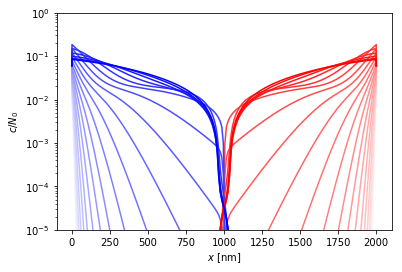

In [8]:
niceplot(solve(5e-11, 5e-11))

## Concentration dependent mobility

1.0                                       

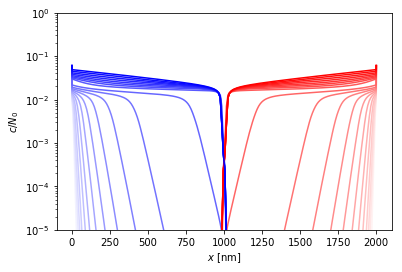

In [9]:
niceplot(solve(5e-11, mu_func))


---
This file is a part of __oedes__, an open source organic electronic device 
simulator. For more information, see <https://www.github.com/mzszym/oedes>.
